In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker
import numpy as np

import uproot
import awkward as ak
from coffea import nanoevents

from coffea.nanoevents.methods.base import NanoEventsArray
from coffea.analysis_tools import Weights, PackedSelection
from coffea.nanoevents.methods import nanoaod
from coffea.nanoevents.methods import vector
from coffea.lookup_tools.dense_lookup import dense_lookup

from HHbbVV.processors.utils import pad_val

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 24})

import warnings

warnings.filterwarnings("ignore")

In [2]:
from datetime import datetime
from pathlib import Path

MAIN_DIR = Path("../../../")
samples_dir = MAIN_DIR / "../data/skimmer/24Mar5AllYears"
# samples_dir = "/ceph/cms/store/user/annava/projects/HHbbVV/24Mar5AllYears"
year = "2016"

# date = "24Mar6"
date = datetime.now().strftime("%Y%m%d")
plot_dir = MAIN_DIR / f"plots/Kinematics/{date}/"
plot_dir.mkdir(parents=True, exist_ok=True)

Look at single SM VBF HH signal NanoAOD file

In [3]:
events = nanoevents.NanoEventsFactory.from_root(
    # "root://cmseos.fnal.gov///store/user/lpcpfnano/cmantill/v2_3/2018/HH/VBF_HHTobbVV_CV_1_C2V__C3_1_TuneCP5_13TeV-madgraph-pythia8/VBF_HHTobbVV_CV_1_C2V_1_C3_1/220808_150149/0000/nano_mc2018_1-1.root",
    "root://cmseos.fnal.gov///store/user/lpcpfnano/cmantill/v2_3/2018/HH/VBF_HHTobbVV_CV_1_C2V_0_C3_1_TuneCP5_13TeV-madgraph-pythia8/VBF_HHTobbVV_CV_1_C2V_0_C3_1/220808_150000/0000/nano_mc2018_1-1.root",
    schemaclass=nanoevents.NanoAODSchema,
).events()

Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25
b_PDGID = 5
GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

Get generator-level Higgs and Vs

In [4]:
higgs = events.GenPart[
    (abs(events.GenPart.pdgId) == HIGGS_PDGID) * events.GenPart.hasFlags(GEN_FLAGS)
]

higgs_children = higgs.children

# finding bb and VV children
is_bb = abs(higgs_children.pdgId) == b_PDGID
is_VV = (abs(higgs_children.pdgId) == W_PDGID) + (abs(higgs_children.pdgId) == Z_PDGID)

Hbb = higgs[ak.any(is_bb, axis=2)]
HVV = higgs[ak.any(is_VV, axis=2)]

# make sure we're only getting one Higgs
Hbb = ak.pad_none(Hbb, 1, axis=1)[:, 0]
HVV = ak.pad_none(HVV, 1, axis=1)[:, 0]

vs = events.GenPart[((abs(events.GenPart.pdgId) == 24)) * events.GenPart.hasFlags(GEN_FLAGS)]

# vbf output quarks are always at index 4, 5
gen_quarks = events.GenPart[events.GenPart.hasFlags(["isHardProcess"])][:, 4:6]

Matching efficiency calculation

In [5]:
def matching_efficiency(gen_quarks, vbf_jets, matching_dr=0.4, verbose=False):
    drs = ak.pad_none(vbf_jets, 2, axis=1)[:, :2].metric_table(gen_quarks)
    matched = drs < matching_dr
    # TODO: add overlap removal?
    matching_fraction = np.mean(np.all(np.any(matched, axis=2), axis=1))
    if verbose:
        print(f"Matching efficiency: {matching_fraction}")
    return matching_fraction

In [6]:
# ak8 jet preselection
preselection = {  # noqa: RUF012
    "pt": 300.0,
    "eta": 2.4,
    "VVmsd": 50,
    # "VVparticleNet_mass": [50, 250],
    # "bbparticleNet_mass": [92.5, 162.5],
    "bbparticleNet_mass": 50,
    "VVparticleNet_mass": 50,
    "bbFatJetParticleNetMD_Txbb": 0.8,
    "jetId": 2,  # tight ID bit
    "DijetMass": 800,  # TODO
    # "nGoodElectrons": 0,
}

In [7]:
num_jets = 2
fatjets = events.FatJet

fatjets = ak.pad_none(
    fatjets[(fatjets.pt > 300) * (fatjets.isTight) * (np.abs(fatjets.eta) <= 2.4)], 2, axis=1
)

# particlenet xbb vs qcd

txbb = pad_val(
    fatjets.particleNetMD_Xbb / (fatjets.particleNetMD_QCD + fatjets.particleNetMD_Xbb),
    num_jets,
    axis=1,
)

# bb VV assignment

bb_mask = txbb[:, 0] >= txbb[:, 1]
bb_mask = np.stack((bb_mask, ~bb_mask)).T

In [8]:
# Leptons
electrons = events.Electron
electrons = electrons[(electrons.pt > 5) & (electrons.cutBased >= electrons.LOOSE)]

muons = events.Muon
muons = muons[(muons.pt > 7) & (muons.looseId)]

In [9]:
sel = ak.fill_none(
    (
        (txbb[bb_mask] > 0.97)
        * (fatjets.particleNet_H4qvsQCD[~bb_mask] > 0.6)
        * (fatjets.pt[:, 0] > 500)
        * (fatjets.pt[:, 1] > 400)
        * (np.abs(fatjets[:, 0].delta_phi(fatjets[:, 1])) > 2.6)
        * (np.abs(fatjets[:, 0].eta - fatjets[:, 1].eta) < 2.0)
    ),
    False,
)

In [10]:
jets = events.Jet

Reproduce AK4 jet selections from skimmer

In [11]:
pt_min_choices = np.arange(0, 50, 1)
effs_pt_min = []
for pt_min in pt_min_choices:
    ak4_jet_selection = {  # noqa: RUF012
        "pt_min": pt_min,
        "pt_max": 300,
        "eta_min": 0,
        "eta_max": 4.7,
        "jetId": "tight",
        "puId": "medium",
        "dR_fatjetbb": 1.2,
        "dR_fatjetVV": 0.8,
    }

    # dR_fatjetVV = 0.8 used from last two cells of VBFgenInfoTests.ipynb with data generated from SM signal vbf
    # https://github.com/rkansal47/HHbbVV/blob/vbf_systematics/src/HHbbVV/VBF_binder/VBFgenInfoTests.ipynb
    # (0-14R1R2study.parquet) has columns of different nGoodVBFJets corresponding to R1 and R2 cuts
    vbf_jet_mask = (
        jets.isTight
        & (jets.pt >= ak4_jet_selection["pt_min"])
        & (jets.pt <= ak4_jet_selection["pt_max"])
        & (np.abs(jets.eta) <= ak4_jet_selection["eta_max"])
        & (np.abs(jets.eta) >= ak4_jet_selection["eta_min"])
        & ((jets.pt > 50) | ((jets.puId & 2) == 2))
        & (
            ak.pad_none(fatjets, num_jets, axis=1, clip=True)[bb_mask].delta_r(jets)
            > ak4_jet_selection["dR_fatjetbb"]
        )
        & (
            ak.pad_none(fatjets, num_jets, axis=1, clip=True)[~bb_mask].delta_r(jets)
            > ak4_jet_selection["dR_fatjetVV"]
        )
        & ak.all(jets.metric_table(electrons) > 0.4, axis=2)
        & ak.all(jets.metric_table(muons) > 0.4, axis=2)
    )

    vbf_jets = jets[vbf_jet_mask]

    eff = matching_efficiency(gen_quarks[sel], vbf_jets[sel], matching_dr=0.4)
    effs_pt_min.append(eff)

Max efficiency 0.342485549132948 at pt_min=0


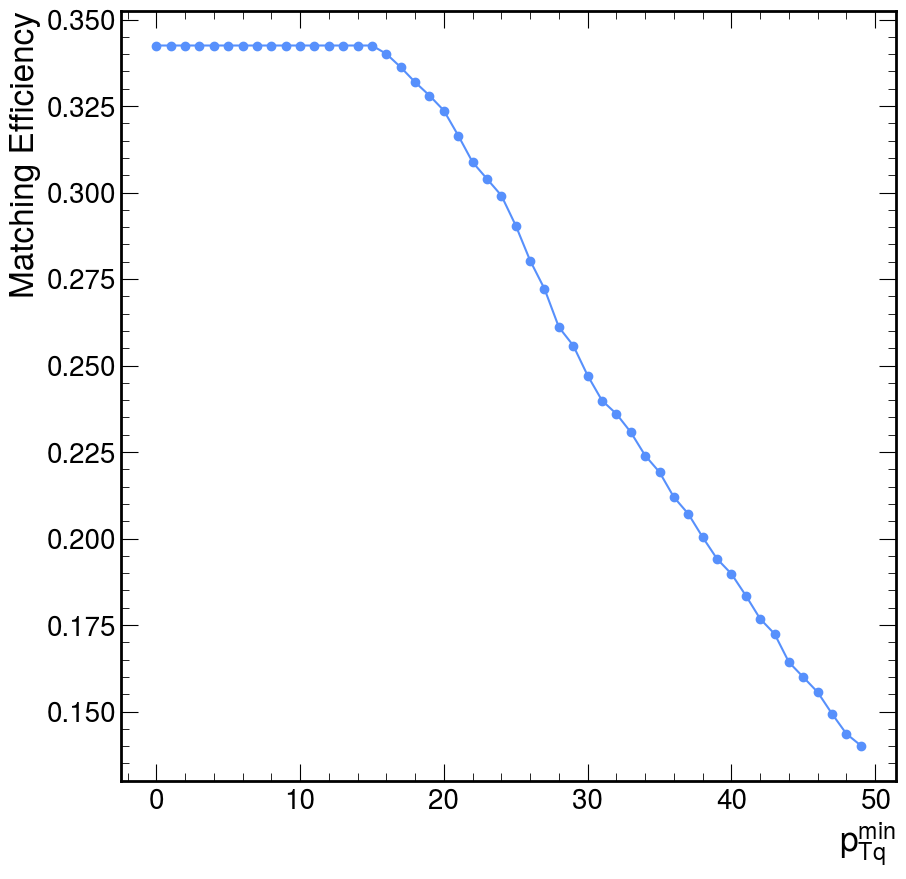

In [12]:
plt.plot(pt_min_choices, effs_pt_min, "o-")
plt.xlabel(r"$p^\mathrm{min}_{Tq}$")
plt.ylabel("Matching Efficiency")
pt_min_argmax = np.argmax(effs_pt_min)
print(f"Max efficiency {effs_pt_min[pt_min_argmax]} at pt_min={pt_min_choices[pt_min_argmax]}")
plt.savefig(plot_dir / "matching_efficiency_vs_pt_min.pdf", bbox_inches="tight")

In [13]:
pt_max_choices = np.arange(300, 1000, 10)
effs_pt_max = []
for pt_max in pt_max_choices:
    ak4_jet_selection = {  # noqa: RUF012
        "pt_min": 0,
        "pt_max": pt_max,
        "eta_min": 0,
        "eta_max": 4.7,
        "jetId": "tight",
        "puId": "medium",
        "dR_fatjetbb": 1.2,
        "dR_fatjetVV": 0.8,
    }

    # dR_fatjetVV = 0.8 used from last two cells of VBFgenInfoTests.ipynb with data generated from SM signal vbf
    # https://github.com/rkansal47/HHbbVV/blob/vbf_systematics/src/HHbbVV/VBF_binder/VBFgenInfoTests.ipynb
    # (0-14R1R2study.parquet) has columns of different nGoodVBFJets corresponding to R1 and R2 cuts
    vbf_jet_mask = (
        jets.isTight
        & (jets.pt >= ak4_jet_selection["pt_min"])
        & (jets.pt <= ak4_jet_selection["pt_max"])
        & (np.abs(jets.eta) <= ak4_jet_selection["eta_max"])
        & (np.abs(jets.eta) >= ak4_jet_selection["eta_min"])
        & ((jets.pt > 50) | ((jets.puId & 2) == 2))
        & (
            ak.pad_none(fatjets, num_jets, axis=1, clip=True)[bb_mask].delta_r(jets)
            > ak4_jet_selection["dR_fatjetbb"]
        )
        & (
            ak.pad_none(fatjets, num_jets, axis=1, clip=True)[~bb_mask].delta_r(jets)
            > ak4_jet_selection["dR_fatjetVV"]
        )
        & ak.all(jets.metric_table(electrons) > 0.4, axis=2)
        & ak.all(jets.metric_table(muons) > 0.4, axis=2)
    )

    vbf_jets = jets[vbf_jet_mask]

    eff = matching_efficiency(gen_quarks[sel], vbf_jets[sel], matching_dr=0.4)
    effs_pt_max.append(eff)

Max efficiency 0.3511560693641618 at eta_max=640


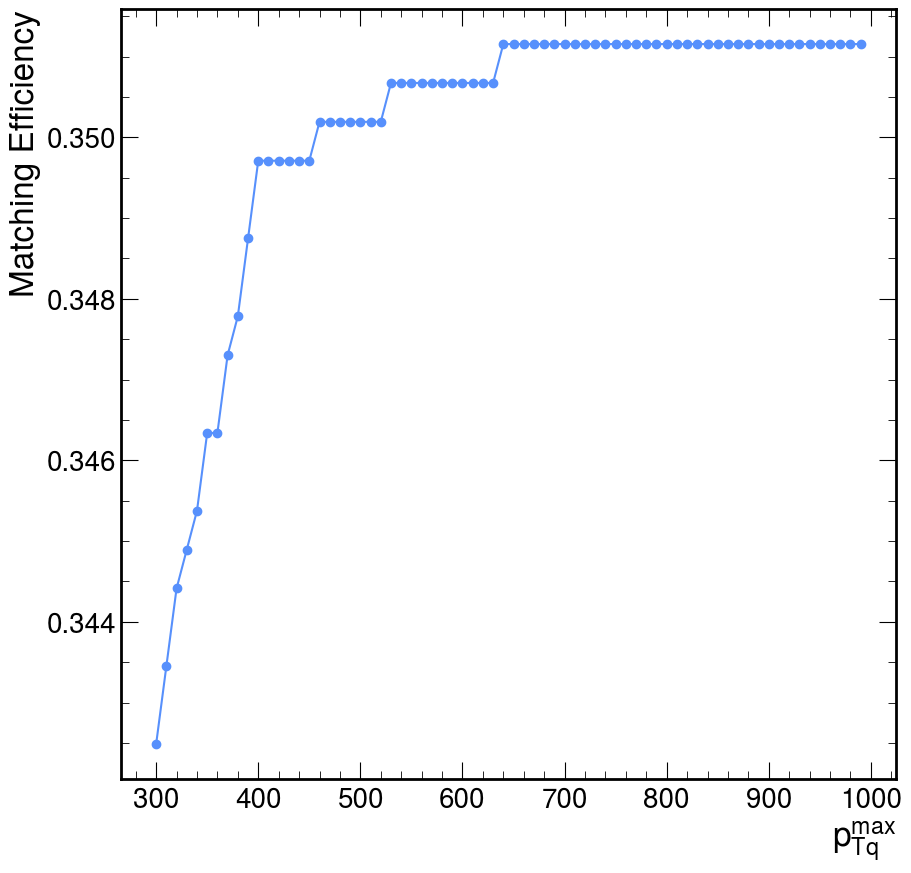

In [14]:
plt.plot(pt_max_choices, effs_pt_max, "o-")
plt.xlabel(r"$p^\mathrm{max}_{Tq}$")
plt.ylabel("Matching Efficiency")
pt_max_argmax = np.argmax(effs_pt_max)
print(f"Max efficiency {effs_pt_max[pt_max_argmax]} at eta_max={pt_max_choices[pt_max_argmax]}")
plt.savefig(plot_dir / "matching_efficiency_vs_pt_max.pdf", bbox_inches="tight")

In [15]:
eta_min_choices = np.arange(0, 4.6, 0.05)
effs_eta_min = []
for eta_min in eta_min_choices:
    ak4_jet_selection = {  # noqa: RUF012
        "pt_min": 15,
        "pt_max": 640,
        "eta_min": eta_min,
        "eta_max": 4.7,
        "jetId": "tight",
        "puId": "medium",
        "dR_fatjetbb": 1.2,
        "dR_fatjetVV": 0.8,
    }

    # dR_fatjetVV = 0.8 used from last two cells of VBFgenInfoTests.ipynb with data generated from SM signal vbf
    # https://github.com/rkansal47/HHbbVV/blob/vbf_systematics/src/HHbbVV/VBF_binder/VBFgenInfoTests.ipynb
    # (0-14R1R2study.parquet) has columns of different nGoodVBFJets corresponding to R1 and R2 cuts
    vbf_jet_mask = (
        jets.isTight
        & (jets.pt >= ak4_jet_selection["pt_min"])
        & (jets.pt <= ak4_jet_selection["pt_max"])
        & (np.abs(jets.eta) <= ak4_jet_selection["eta_max"])
        & (np.abs(jets.eta) >= ak4_jet_selection["eta_min"])
        & ((jets.pt > 50) | ((jets.puId & 2) == 2))
        & (
            ak.pad_none(fatjets, num_jets, axis=1, clip=True)[bb_mask].delta_r(jets)
            > ak4_jet_selection["dR_fatjetbb"]
        )
        & (
            ak.pad_none(fatjets, num_jets, axis=1, clip=True)[~bb_mask].delta_r(jets)
            > ak4_jet_selection["dR_fatjetVV"]
        )
        & ak.all(jets.metric_table(electrons) > 0.4, axis=2)
        & ak.all(jets.metric_table(muons) > 0.4, axis=2)
    )

    vbf_jets = jets[vbf_jet_mask]

    eff = matching_efficiency(gen_quarks[sel], vbf_jets[sel], matching_dr=0.4)
    effs_eta_min.append(eff)

Max efficiency 0.3516377649325626 at eta_min=0.25


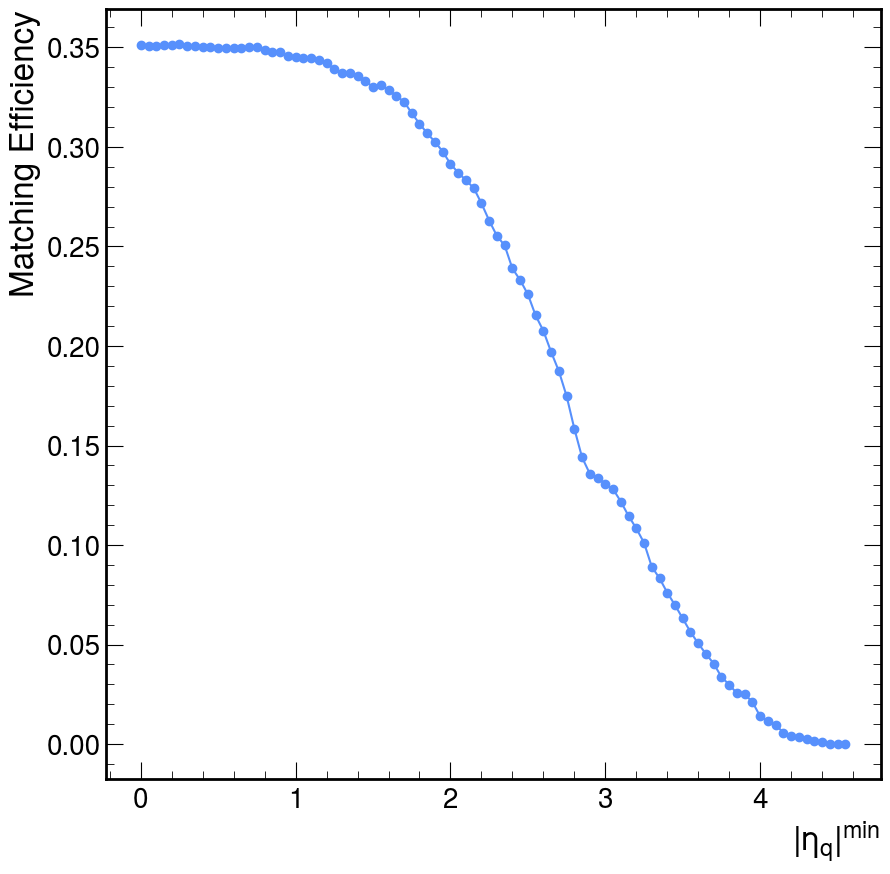

In [16]:
plt.plot(eta_min_choices, effs_eta_min, "o-")
plt.xlabel(r"$|\eta_{q}|^\mathrm{min}$")
plt.ylabel("Matching Efficiency")
eta_min_argmax = np.argmax(effs_eta_min)
print(f"Max efficiency {effs_eta_min[eta_min_argmax]} at eta_min={eta_min_choices[eta_min_argmax]}")
plt.savefig(plot_dir / "matching_efficiency_vs_eta_min.pdf", bbox_inches="tight")
plt.show()

In [17]:
eta_max_choices = np.arange(1.4, 10, 0.1)
effs_eta_max = []
for eta_max in eta_max_choices:
    ak4_jet_selection = {  # noqa: RUF012
        "pt_min": 15,
        "pt_max": 640,
        "eta_min": 0.25,
        "eta_max": eta_max,
        "jetId": "tight",
        "puId": "medium",
        "dR_fatjetbb": 1.2,
        "dR_fatjetVV": 0.8,
    }

    # dR_fatjetVV = 0.8 used from last two cells of VBFgenInfoTests.ipynb with data generated from SM signal vbf
    # https://github.com/rkansal47/HHbbVV/blob/vbf_systematics/src/HHbbVV/VBF_binder/VBFgenInfoTests.ipynb
    # (0-14R1R2study.parquet) has columns of different nGoodVBFJets corresponding to R1 and R2 cuts
    vbf_jet_mask = (
        jets.isTight
        & (jets.pt >= ak4_jet_selection["pt_min"])
        & (jets.pt <= ak4_jet_selection["pt_max"])
        & (np.abs(jets.eta) <= ak4_jet_selection["eta_max"])
        & (np.abs(jets.eta) >= ak4_jet_selection["eta_min"])
        & ((jets.pt > 50) | ((jets.puId & 2) == 2))
        & (
            ak.pad_none(fatjets, num_jets, axis=1, clip=True)[bb_mask].delta_r(jets)
            > ak4_jet_selection["dR_fatjetbb"]
        )
        & (
            ak.pad_none(fatjets, num_jets, axis=1, clip=True)[~bb_mask].delta_r(jets)
            > ak4_jet_selection["dR_fatjetVV"]
        )
        & ak.all(jets.metric_table(electrons) > 0.4, axis=2)
        & ak.all(jets.metric_table(muons) > 0.4, axis=2)
    )

    vbf_jets = jets[vbf_jet_mask]

    eff = matching_efficiency(gen_quarks[sel], vbf_jets[sel], matching_dr=0.4)
    effs_eta_max.append(eff)

Max efficiency 0.3578998073217726 at eta_max=4.900000000000003


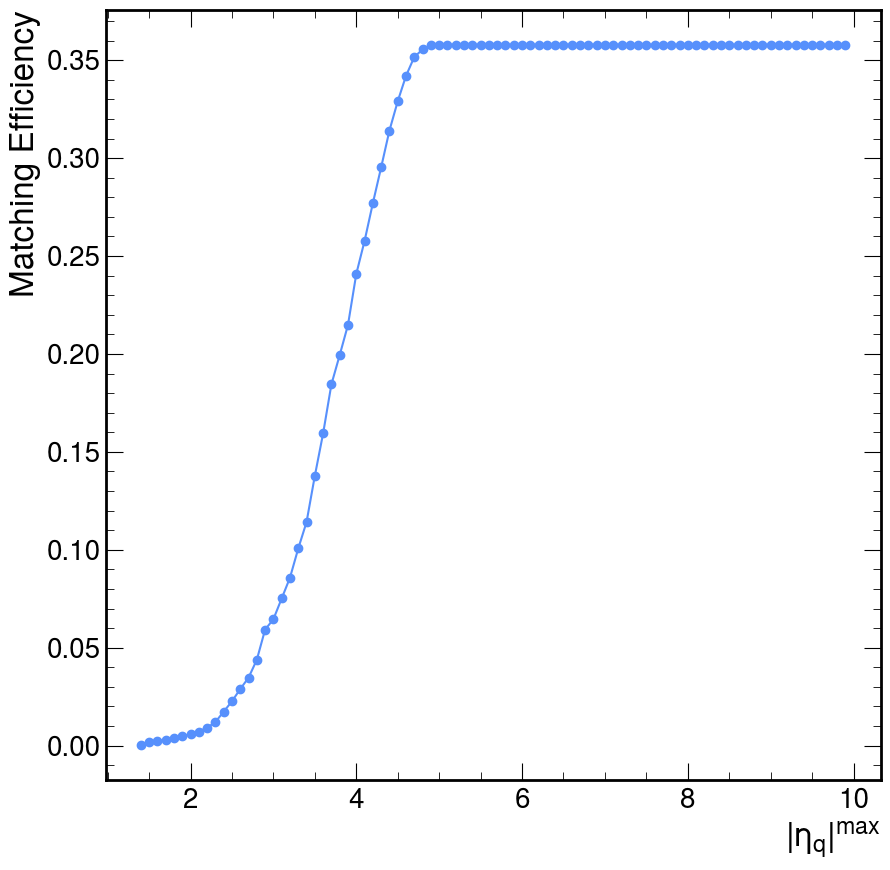

In [18]:
plt.plot(eta_max_choices, effs_eta_max, "o-")
plt.xlabel(r"$|\eta_{q}|^\mathrm{max}$")
plt.ylabel("Matching Efficiency")
eta_max_argmax = np.argmax(effs_eta_max)
print(f"Max efficiency {effs_eta_max[eta_max_argmax]} at eta_max={eta_max_choices[eta_max_argmax]}")
plt.savefig(plot_dir / "matching_efficiency_vs_eta_max.pdf", bbox_inches="tight")
plt.show()

In [19]:
dR_fatjetbb_choices = np.arange(0, 2, 0.1)
effs_dR_fatjetbb = []
for dR_fatjetbb in dR_fatjetbb_choices:
    ak4_jet_selection = {  # noqa: RUF012
        "pt_min": 15,
        "pt_max": 640,
        "eta_min": 0.25,
        "eta_max": 4.9,
        "jetId": "tight",
        "puId": "medium",
        "dR_fatjetbb": dR_fatjetbb,
        "dR_fatjetVV": 0.8,
    }

    # dR_fatjetVV = 0.8 used from last two cells of VBFgenInfoTests.ipynb with data generated from SM signal vbf
    # https://github.com/rkansal47/HHbbVV/blob/vbf_systematics/src/HHbbVV/VBF_binder/VBFgenInfoTests.ipynb
    # (0-14R1R2study.parquet) has columns of different nGoodVBFJets corresponding to R1 and R2 cuts
    vbf_jet_mask = (
        jets.isTight
        & (jets.pt >= ak4_jet_selection["pt_min"])
        & (jets.pt <= ak4_jet_selection["pt_max"])
        & (np.abs(jets.eta) <= ak4_jet_selection["eta_max"])
        & (np.abs(jets.eta) >= ak4_jet_selection["eta_min"])
        & ((jets.pt > 50) | ((jets.puId & 2) == 2))
        & (
            ak.pad_none(fatjets, num_jets, axis=1, clip=True)[bb_mask].delta_r(jets)
            > ak4_jet_selection["dR_fatjetbb"]
        )
        & (
            ak.pad_none(fatjets, num_jets, axis=1, clip=True)[~bb_mask].delta_r(jets)
            > ak4_jet_selection["dR_fatjetVV"]
        )
        & ak.all(jets.metric_table(electrons) > 0.4, axis=2)
        & ak.all(jets.metric_table(muons) > 0.4, axis=2)
    )

    vbf_jets = jets[vbf_jet_mask]

    eff = matching_efficiency(gen_quarks[sel], vbf_jets[sel], matching_dr=0.4)
    effs_dR_fatjetbb.append(eff)

Max efficiency 0.3578998073217726 at dR_fatjetbb=1.0


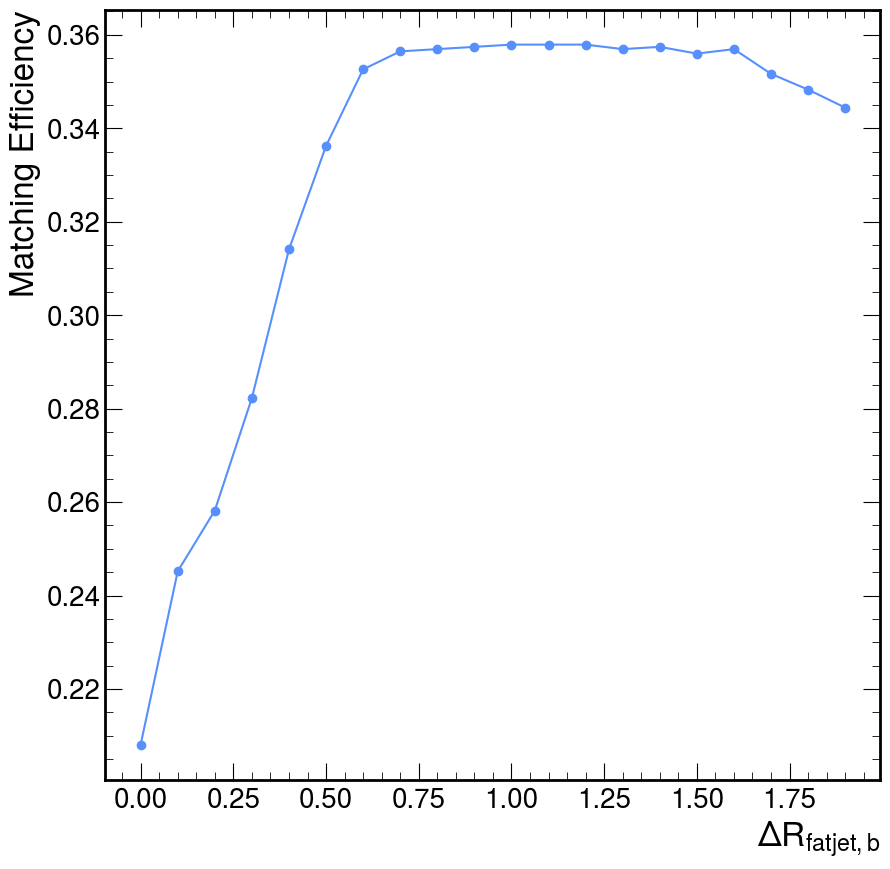

In [20]:
plt.plot(dR_fatjetbb_choices, effs_dR_fatjetbb, "o-")
plt.xlabel(r"$\Delta R_{\mathrm{fatjet, b}}$")
plt.ylabel("Matching Efficiency")
dR_fatjetbb_argmax = np.argmax(effs_dR_fatjetbb)
print(
    f"Max efficiency {effs_dR_fatjetbb[dR_fatjetbb_argmax]} at dR_fatjetbb={dR_fatjetbb_choices[dR_fatjetbb_argmax]}"
)
plt.savefig(plot_dir / "matching_efficiency_vs_dR_fatjetbb.pdf", bbox_inches="tight")
plt.show()

In [21]:
dR_fatjetVV_choices = np.arange(0, 2, 0.05)
effs_dR_fatjetVV = []
for dR_fatjetVV in dR_fatjetVV_choices:
    ak4_jet_selection = {  # noqa: RUF012
        "pt_min": 15,
        "pt_max": 640,
        "eta_min": 0.25,
        "eta_max": 4.9,
        "jetId": "tight",
        "puId": "medium",
        "dR_fatjetbb": 1.0,
        "dR_fatjetVV": dR_fatjetVV,
    }

    # dR_fatjetVV = 0.8 used from last two cells of VBFgenInfoTests.ipynb with data generated from SM signal vbf
    # https://github.com/rkansal47/HHbbVV/blob/vbf_systematics/src/HHbbVV/VBF_binder/VBFgenInfoTests.ipynb
    # (0-14R1R2study.parquet) has columns of different nGoodVBFJets corresponding to R1 and R2 cuts
    vbf_jet_mask = (
        jets.isTight
        & (jets.pt >= ak4_jet_selection["pt_min"])
        & (jets.pt <= ak4_jet_selection["pt_max"])
        & (np.abs(jets.eta) <= ak4_jet_selection["eta_max"])
        & (np.abs(jets.eta) >= ak4_jet_selection["eta_min"])
        & ((jets.pt > 50) | ((jets.puId & 2) == 2))
        & (
            ak.pad_none(fatjets, num_jets, axis=1, clip=True)[bb_mask].delta_r(jets)
            > ak4_jet_selection["dR_fatjetbb"]
        )
        & (
            ak.pad_none(fatjets, num_jets, axis=1, clip=True)[~bb_mask].delta_r(jets)
            > ak4_jet_selection["dR_fatjetVV"]
        )
        & ak.all(jets.metric_table(electrons) > 0.4, axis=2)
        & ak.all(jets.metric_table(muons) > 0.4, axis=2)
    )

    vbf_jets = jets[vbf_jet_mask]

    eff = matching_efficiency(gen_quarks[sel], vbf_jets[sel], matching_dr=0.4)
    effs_dR_fatjetVV.append(eff)

Max efficiency 0.3578998073217726 at dR_fatjetVV=0.75


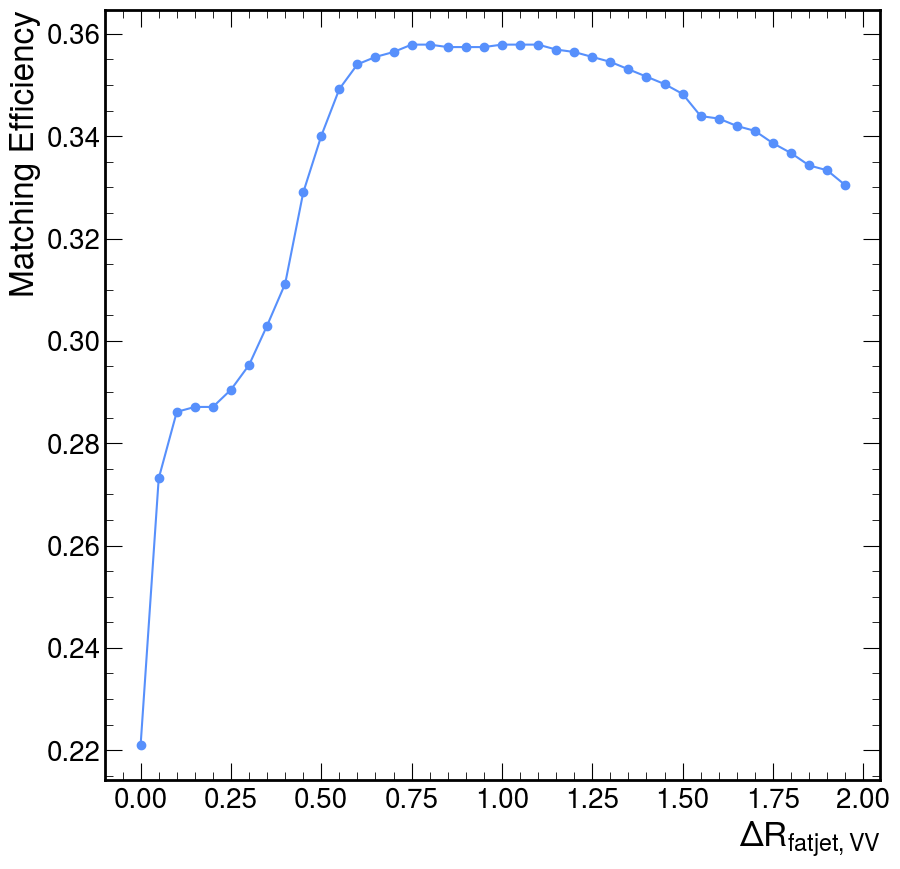

In [22]:
plt.plot(dR_fatjetVV_choices, effs_dR_fatjetVV, "o-")
plt.xlabel(r"$\Delta R_{\mathrm{fatjet, VV}}$")
plt.ylabel("Matching Efficiency")
dR_fatjetVV_argmax = np.argmax(effs_dR_fatjetVV)
print(
    f"Max efficiency {effs_dR_fatjetVV[dR_fatjetVV_argmax]} at dR_fatjetVV={dR_fatjetVV_choices[dR_fatjetVV_argmax]}"
)
plt.savefig(plot_dir / "matching_efficiency_vs_dR_fatjetVV.pdf", bbox_inches="tight")
plt.show()

# Final Selections

In [23]:
ak4_jet_selection = {  # noqa: RUF012
    "pt_min": 15,
    "pt_max": 640,
    "eta_min": 0.25,
    "eta_max": 4.9,
    "jetId": "tight",
    "puId": "medium",
    "dR_fatjetbb": 1.0,
    "dR_fatjetVV": 0.75,
}

# dR_fatjetVV = 0.8 used from last two cells of VBFgenInfoTests.ipynb with data generated from SM signal vbf
# https://github.com/rkansal47/HHbbVV/blob/vbf_systematics/src/HHbbVV/VBF_binder/VBFgenInfoTests.ipynb
# (0-14R1R2study.parquet) has columns of different nGoodVBFJets corresponding to R1 and R2 cuts
vbf_jet_mask = (
    jets.isTight
    & (jets.pt >= ak4_jet_selection["pt_min"])
    & (jets.pt <= ak4_jet_selection["pt_max"])
    & (np.abs(jets.eta) <= ak4_jet_selection["eta_max"])
    & (np.abs(jets.eta) >= ak4_jet_selection["eta_min"])
    & ((jets.pt > 50) | ((jets.puId & 2) == 2))
    & (
        ak.pad_none(fatjets, num_jets, axis=1, clip=True)[bb_mask].delta_r(jets)
        > ak4_jet_selection["dR_fatjetbb"]
    )
    & (
        ak.pad_none(fatjets, num_jets, axis=1, clip=True)[~bb_mask].delta_r(jets)
        > ak4_jet_selection["dR_fatjetVV"]
    )
    & ak.all(jets.metric_table(electrons) > 0.4, axis=2)
    & ak.all(jets.metric_table(muons) > 0.4, axis=2)
)


vbf_jets = jets[vbf_jet_mask]

eff = matching_efficiency(gen_quarks[sel], vbf_jets[sel], matching_dr=0.4)
print(f"Matching efficiency: {eff}")

Matching efficiency: 0.3578998073217726
